# Библиотеки

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_training
import plotting_utils

In [9]:
# run this function if you need to generate a csv data set from scratch
#data_loader.generate_csv_dataset()

In [10]:
X, y, ID = data_loader.load_dataset()

data loaded in 0.019922733306884766ms
          0         1         2         3         4         5         6  \
0  0.303588 -0.523626 -0.651190 -1.467650 -0.572507 -0.280386 -1.388246   
1 -0.484031 -0.262126  0.091142 -1.006777 -0.035807 -0.231770 -0.857022   
2 -0.957440  0.698818 -0.176248 -0.617123 -0.010873  0.925743  0.071460   
3  0.902663 -1.304844 -0.068376 -1.963072 -0.379324 -0.518108 -1.383540   
4  0.506352 -1.478475 -0.688782 -1.687141 -0.489462 -0.443938 -1.347390   

          7         8         9  ...        70        71        72        73  \
0 -0.950745 -2.033666  0.623800  ...  0.116454  1.707008  0.930117  0.145040   
1 -0.493470 -1.053105  0.319601  ...  2.131210  1.565413  0.606471  0.574687   
2 -0.362686 -0.772299  0.671955  ...  0.986818  1.921790  1.916645  2.079151   
3 -0.763318 -2.130993  0.063363  ... -0.442807 -0.534647  0.323451  0.133644   
4 -0.153102 -1.409550  0.290466  ... -0.621059  0.381151  0.202425 -0.084719   

         74        75        7

In [11]:
ID['0'].unique()    # actors

array([22,  9, 18,  6, 24,  3, 21, 12, 14, 15,  5, 20, 23,  4,  8, 13, 11,
       10,  7,  2, 19,  1, 17, 16])

In [12]:
group_members= data_loader.get_k_fold_group_member()


X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X, y, ID, group_members)
print(len(X_k_folds))

5


## SVM with Linear kernel

### Train & evaluate function

### Grid Search (C)

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.74it/s]

UAR = 0.415


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 17.36it/s]

UAR = 0.423


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 16.71it/s]

UAR = 0.438


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.19it/s]

UAR = 0.416


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  8.71it/s]

UAR = 0.411


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.71it/s]

UAR = 0.408


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.77it/s]

UAR = 0.394


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.95it/s]

UAR = 0.398


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.14it/s]

UAR = 0.407


Text(0, 0.5, 'UAR')

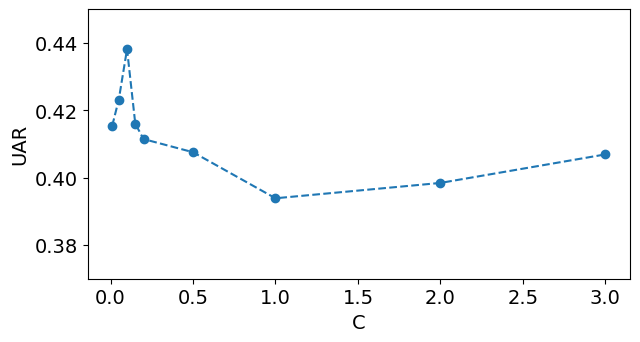

In [13]:
C = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 1.0, 2.0, 3.0]
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5))
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.45])
plt.xlabel('C')
plt.ylabel('UAR')

## Results and confusion matrix

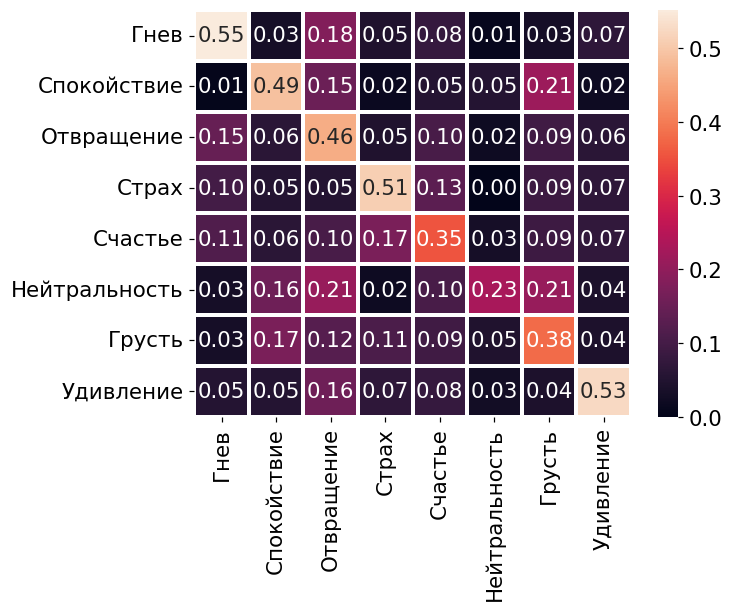

Saving confusion matrix with name:  Doc/figures/confusion_matrix.jpg


In [14]:
plotting_utils.plot_confusion_matrix(y_test, y_true, y_pred)

# SVM (version 2)

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 19.63it/s]

UAR = 0.419


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 18.17it/s]

UAR = 0.432


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 15.50it/s]

UAR = 0.442


 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                              | 2/5 [00:00<00:00, 13.63it/s]

UAR = 0.427


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  9.22it/s]

UAR = 0.424


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  7.38it/s]

UAR = 0.410


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  6.09it/s]

UAR = 0.399


 20%|████████████████████████████████████▊                                                                                                                                                   | 1/5 [00:00<00:00,  5.68it/s]

UAR = 0.406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.79it/s]


UAR = 0.410


Text(0, 0.5, 'UAR')

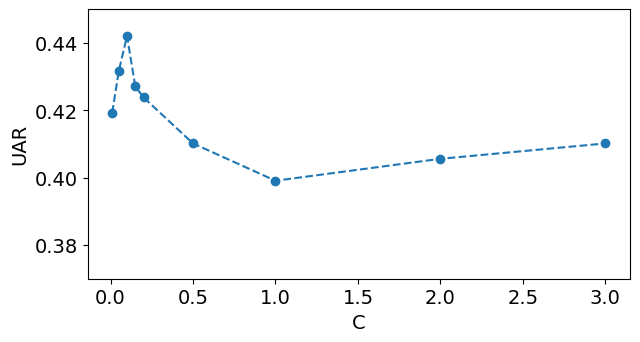

In [16]:
C = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 1.0, 2.0, 3.0]
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C, decision_function_shape='ovr',break_ties=True)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5))
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.45])
plt.xlabel('C')
plt.ylabel('UAR')